<a href="https://colab.research.google.com/github/romitbarua/MultiModalDeepFake/blob/main/TestingNotebooks/PhonemeVsDlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#mount the google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
!pip install moviepy
!pip3 install imageio==2.4.1
!pip install imageio-ffmpeg
!pip install textgrid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
#import appropriate packages
import os
import cv2
import dlib
from google.colab.patches import cv2_imshow
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import itertools
from moviepy.editor import *
import textgrid

In [19]:
SYM_PATH = '/content/drive/MyDrive/DeepFakeDetection'
%cd $SYM_PATH
%pip install -e .

/content/drive/MyDrive/DeepFakeDetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/DeepFakeDetection
  Attempting uninstall: DeepFake
    Found existing installation: DeepFake 0.1.0
    Can't uninstall 'DeepFake'. No files were found to uninstall.
  Running setup.py develop for DeepFake


In [20]:
#import custom packages
from packages.DlibManager import DlibManager

predictor_path = '/content/drive/MyDrive/DeepFakeDetection/model/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
     

In [21]:
#load the metadata
id = 'id01610'

metadata = pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/full_metadata.csv')
metadata = metadata[(metadata['valid_dlib']==True) & (metadata['phoneme_path'].isna() == False)]

In [22]:
metadata[(metadata['video_source'] == 'VoxCeleb') & (metadata['source'] == id)]

,Unnamed: 0,source,path,directory,full_path,type,method,video_source,wav_path,utterance_path,phoneme_path,Unnamed: 0.1,valid_dlib,target1,target2,category,race,gender


In [23]:
real_videos = metadata[metadata['method'] == 'real'].sample(frac=1, replace=False).reset_index(drop=True)
fake_videos = metadata[metadata['method'] == 'wav2lip'].sample(frac=1, replace=False).reset_index(drop=True)

train_perc = 0.8

train_real = real_videos[0:int(real_videos.shape[0]*train_perc)]
test_real = real_videos[int(real_videos.shape[0]*train_perc):]
test_fake = fake_videos[:test_real.shape[0]]

In [24]:
def distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2)**2))

In [25]:
def normalize(ar, mean=None, std=None):
  if isinstance(mean, type(None)):
    mean = np.mean(ar)
  if isinstance(std, type(None)):
    std = np.std(ar)
    
  return (ar - mean)/std

In [26]:
def generate_features(dlib_video, phonemes, phoneme_time_adj, dlib_frame_ext, full_path):

  top_lip_idx = 52
  bottom_lip_idx = 58
  left_lip_idx = 49
  right_lip_idx = 55
  nose_idx = 34
  chin_idx = 9

  features = []

  duration = phonemes[-1].maxTime

  dlib_frames = dlib_video.full_frames
  landmarks = dlib_video.landmarks

  second_per_frame = duration/len(dlib_frames)
  dlib_frame_times = np.arange(0, len(dlib_frames), 1)*second_per_frame


  full_video_vert_lip_distance = np.array([distance(landmark[top_lip_idx], landmark[bottom_lip_idx]) for landmark in landmarks])
  full_video_hor_lip_distance = np.array([distance(landmark[left_lip_idx], landmark[right_lip_idx]) for landmark in landmarks])
  full_video_nose_chin_distance = np.array([distance(landmark[nose_idx], landmark[chin_idx]) for landmark in landmarks])
  full_video_mouth_ratio = full_video_vert_lip_distance/full_video_hor_lip_distance

  full_video_vert_mean = np.mean(full_video_vert_lip_distance)
  full_video_vert_std = np.std(full_video_vert_lip_distance)
  full_video_hor_mean = np.mean(full_video_hor_lip_distance)
  full_video_hor_st = np.std(full_video_hor_lip_distance)
  full_video_nose_chin_mean = np.mean(full_video_nose_chin_distance)
  full_video_nose_chin_std = np.std(full_video_nose_chin_distance)
  full_video_mouth_ratio_mean = np.mean(full_video_mouth_ratio)
  full_video_mouth_ratio_std = np.std(full_video_mouth_ratio)

  for phoneme in phonemes:

    start_time, end_time = phoneme.minTime-phoneme_time_adj, phoneme.maxTime+phoneme_time_adj

    start_frame_idx = max(abs(dlib_frame_times - start_time).argmin() - dlib_frame_ext,0)
    end_frame_idx = min(abs(dlib_frame_times - end_time).argmin() + dlib_frame_ext, len(dlib_frames))

    phoneme_landmark = landmarks[start_frame_idx:end_frame_idx]

    vert_lip_distance = np.array([distance(landmark[top_lip_idx], landmark[bottom_lip_idx]) for landmark in phoneme_landmark])
    hor_lip_distance = np.array([distance(landmark[left_lip_idx], landmark[right_lip_idx]) for landmark in phoneme_landmark])
    nose_chin_distance = np.array([distance(landmark[nose_idx], landmark[chin_idx]) for landmark in phoneme_landmark])
    mouth_ratio = vert_lip_distance/hor_lip_distance

    vert_lip_distance = normalize(vert_lip_distance, full_video_vert_mean, full_video_vert_std)
    hor_lip_distance = normalize(hor_lip_distance, full_video_hor_mean, full_video_hor_st)
    nose_chin_distance = normalize(nose_chin_distance, full_video_nose_chin_mean, full_video_nose_chin_std)
    mouth_ratio = normalize(mouth_ratio, full_video_mouth_ratio_mean, full_video_mouth_ratio_std)

    vert_lip_distance_max = vert_lip_distance.max()
    vert_lip_distance_min = vert_lip_distance.min()
    vert_lip_distance_diff = vert_lip_distance_max - vert_lip_distance_min
    vert_lip_distance_std = vert_lip_distance.std()
    vert_lip_distance_mean = vert_lip_distance.mean()

    hor_lip_distance_max = hor_lip_distance.max()
    hor_lip_distance_min = hor_lip_distance.min()
    hor_lip_distance_diff = hor_lip_distance_max - hor_lip_distance_min
    hor_lip_distance_std = hor_lip_distance.std()
    hor_lip_distance_mean = hor_lip_distance.mean()

    nose_chin_distance_max = nose_chin_distance.max()
    nose_chin_distance_min = nose_chin_distance.min()
    nose_chin_distance_diff = nose_chin_distance_max - nose_chin_distance_min
    nose_chin_distance_std = nose_chin_distance.std()
    nose_chin_distance_mean = nose_chin_distance.mean()

    mouth_ratio_max = mouth_ratio.max()
    mouth_ratio_min = mouth_ratio.min()
    mouth_ratio_diff = mouth_ratio_max - mouth_ratio_min
    mouth_ratio_std = mouth_ratio.std()
    mouth_ratio_mean = mouth_ratio.mean()

    features.append([full_path, phoneme.mark, len(phoneme_landmark), start_time, end_time, start_frame_idx, end_frame_idx,
                     vert_lip_distance_max, vert_lip_distance_min, vert_lip_distance_diff, vert_lip_distance_std, vert_lip_distance_mean,
                     hor_lip_distance_max, hor_lip_distance_min, hor_lip_distance_diff, hor_lip_distance_std, hor_lip_distance_mean, 
                     nose_chin_distance_max, nose_chin_distance_min, nose_chin_distance_diff, nose_chin_distance_std, nose_chin_distance_mean,
                     mouth_ratio_max, mouth_ratio_min, mouth_ratio_diff, mouth_ratio_std, mouth_ratio_mean ])
    
  return features


  






In [27]:
#1 for each video, extract the phoneme
#2 for each phoneme, using moviepy, get the frames associated with the phoneme
#3 get the landmarks associated with each frame
#4 return list of phoneme & landmarks
def extract(data, phoneme_time_adj, dlib_frame_ext):

  full_results = []

  idx = 0
  for index, row in data.iterrows():

    video_results = []

    print(f'\r Running Video {idx+1} of {data.shape[0]}', end='')


    phonemes = textgrid.TextGrid.fromFile(row['phoneme_path'])[1]

    video = cv2.VideoCapture(row['full_path'])
    dlib_video = DlibManager(detector=detector, predictor=predictor, video=video)

    full_results.extend(generate_features(dlib_video, phonemes, phoneme_time_adj, dlib_frame_ext, row['full_path']))

    idx += 1

  return pd.DataFrame(full_results, columns=['full_path', 'phoneme', 'num_frames', 'phoneme_start', 'phoneme_end', 'frame_start', 'frame_end',
                                            'vert_lip_max', 'vert_lip_min', 'vert_lip_diff', 'vert_lip_std', 'vert_lip_mean',
                                            'hor_lip_max', 'hor_lip_min', 'hor_lip_diff', 'hor_lip_std', 'hor_lip_mean',
                                            'nose_chin_max', 'nose_chin_min', 'nose_chin_diff', 'nose_chin_std', 'nose_chin_mean',
                                            'mouth_ratio_max', 'mouth_ratio_min', 'mouth_ratio_diff', 'mouth_ratio_std', 'mouth_ratio_mean'])

    



In [54]:
train_df = extract(train_real, 0.15, 0)
test__real_df = extract(test_real, 0, 1)
test__fake_df = extract(test_fake, 0, 1)

 Running Video 79 of 79

## Exploratory Data Analysis

In [55]:
train_df.head()

,full_path,phoneme,num_frames,phoneme_start,phoneme_end,frame_start,frame_end,vert_lip_max,vert_lip_min,vert_lip_diff,...,nose_chin_max,nose_chin_min,nose_chin_diff,nose_chin_std,nose_chin_mean,mouth_ratio_max,mouth_ratio_min,mouth_ratio_diff,mouth_ratio_std,mouth_ratio_mean
0,/content/drive/MyDrive/DeepFakeDetection/data/...,S,7,-0.15,0.27,0,7,0.907192,-0.705619,1.612811,...,1.675459,-0.171428,1.846886,0.657981,0.889943,1.860422,-0.146205,2.006627,0.712016,0.970273
1,/content/drive/MyDrive/DeepFakeDetection/data/...,OW1,13,-0.03,0.52,0,13,0.907192,-1.083223,1.990415,...,1.675459,-0.171428,1.846886,0.621771,0.557517,1.860422,-0.146205,2.006627,0.635288,0.667377
2,/content/drive/MyDrive/DeepFakeDetection/data/...,Y,10,0.22,0.62,5,15,0.702826,-1.083223,1.786049,...,1.675459,0.004354,1.671104,0.490697,0.443956,1.277528,-0.404714,1.682242,0.462267,0.355722
3,/content/drive/MyDrive/DeepFakeDetection/data/...,UW1,8,0.32,0.65,8,16,0.702826,-0.968985,1.671811,...,0.684908,-0.418673,1.103581,0.341861,0.207021,0.771210,-0.785804,1.557014,0.448193,0.053395
4,/content/drive/MyDrive/DeepFakeDetection/data/...,G,10,0.35,0.76,9,19,0.702826,-0.968985,1.671811,...,0.684908,-0.674401,1.359309,0.433350,0.092695,0.314000,-1.518472,1.832472,0.714913,-0.466691


In [56]:
phoneme_df = (train_df['phoneme'].value_counts()/train_df.shape[0]).reset_index()
phoneme_df

,index,phoneme
0,T,0.072786
1,AH0,0.069081
2,N,0.063633
3,,0.050907
4,S,0.041318
...,...,...
62,ZH,0.000131
63,ER2,0.000131
64,AO0,0.000087
65,UH2,0.000087


In [57]:
phoneme_df['index'].unique()

array(['T', 'AH0', 'N', '', 'S', 'IH0', 'D', 'R', 'L', 'DH', 'M', 'K',
       'AY1', 'AE1', 'W', 'Z', 'EH1', 'IH1', 'AH1', 'IY1', 'IY0', 'V',
       'B', 'P', 'F', 'HH', 'ER0', 'AA1', 'OW1', 'UW1', 'EY1', 'NG',
       'spn', 'Y', 'AO1', 'G', 'TH', 'SH', 'AW1', 'ER1', 'JH', 'CH',
       'UH1', 'IH2', 'EY2', 'AH2', 'EH2', 'OW0', 'AY2', 'AA2', 'UW0',
       'AO2', 'AE2', 'IY2', 'OW2', 'OY1', 'EH0', 'AE0', 'EY0', 'AA0',
       'AY0', 'UW2', 'ZH', 'ER2', 'AO0', 'UH2', 'UH0'], dtype=object)

In [58]:
train_df.columns

Index(['full_path', 'phoneme', 'num_frames', 'phoneme_start', 'phoneme_end',
       'frame_start', 'frame_end', 'vert_lip_max', 'vert_lip_min',
       'vert_lip_diff', 'vert_lip_std', 'vert_lip_mean', 'hor_lip_max',
       'hor_lip_min', 'hor_lip_diff', 'hor_lip_std', 'hor_lip_mean',
       'nose_chin_max', 'nose_chin_min', 'nose_chin_diff', 'nose_chin_std',
       'nose_chin_mean', 'mouth_ratio_max', 'mouth_ratio_min',
       'mouth_ratio_diff', 'mouth_ratio_std', 'mouth_ratio_mean'],
      dtype='object')

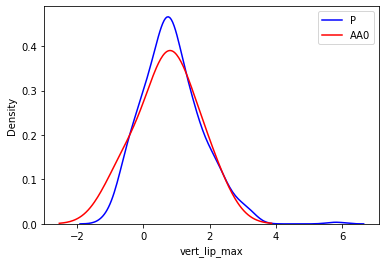

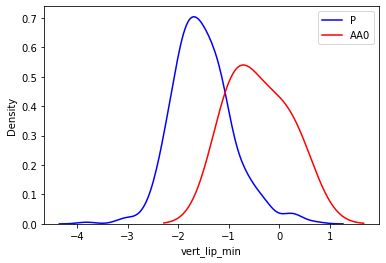

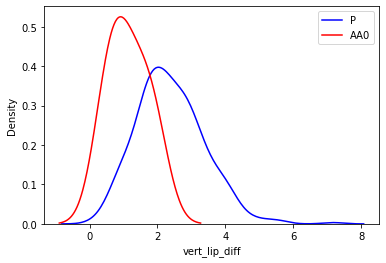

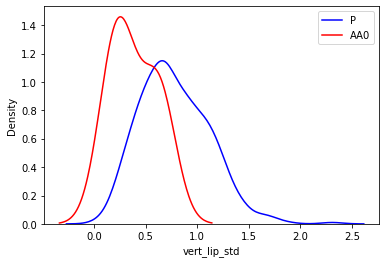

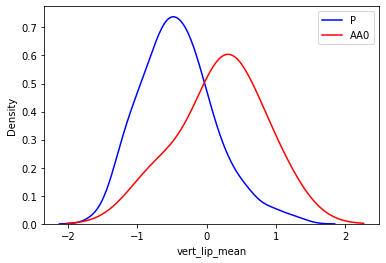

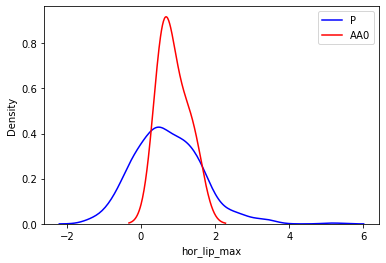

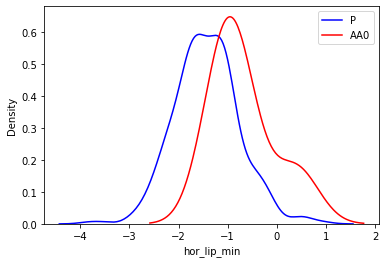

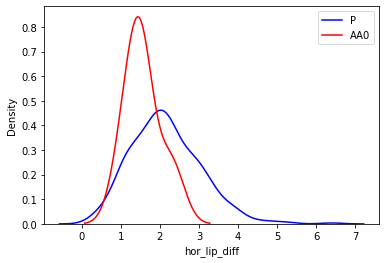

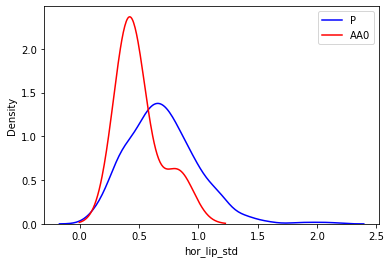

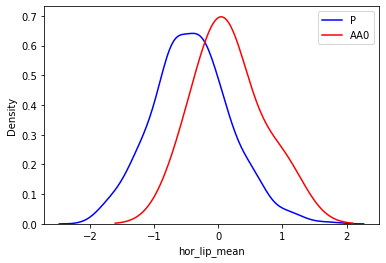

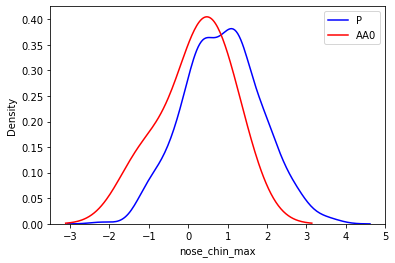

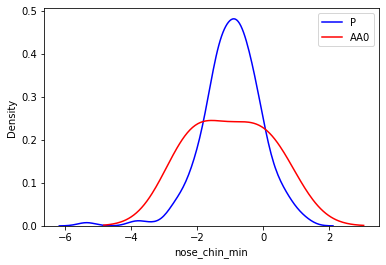

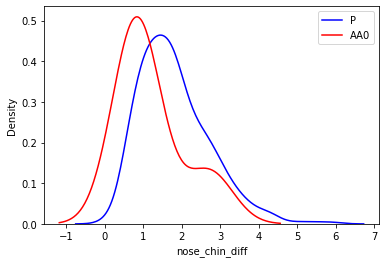

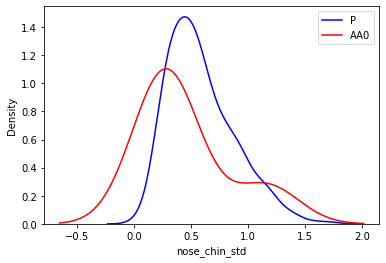

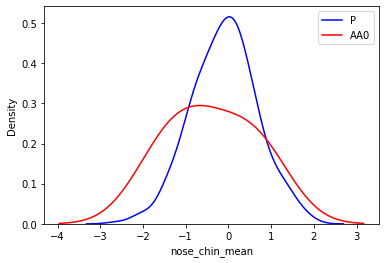

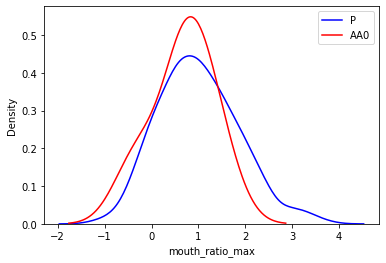

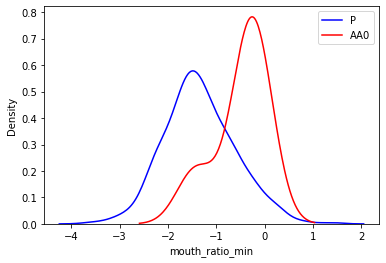

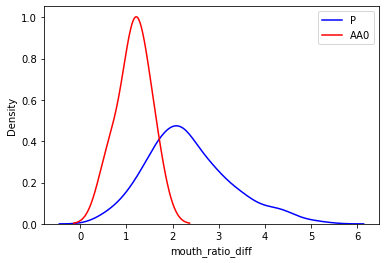

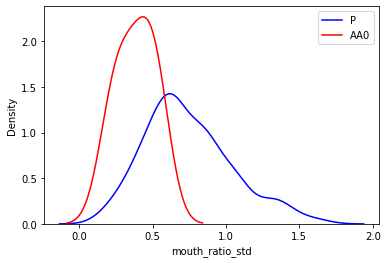

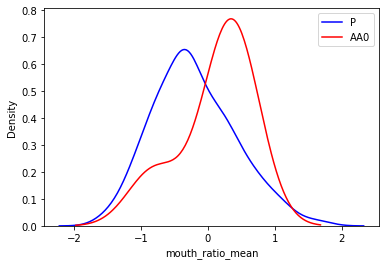

In [59]:
cols = ['vert_lip_max', 'vert_lip_min',
       'vert_lip_diff', 'vert_lip_std', 'vert_lip_mean', 'hor_lip_max',
       'hor_lip_min', 'hor_lip_diff', 'hor_lip_std', 'hor_lip_mean',
       'nose_chin_max', 'nose_chin_min', 'nose_chin_diff', 'nose_chin_std',
       'nose_chin_mean', 'mouth_ratio_max', 'mouth_ratio_min',
       'mouth_ratio_diff', 'mouth_ratio_std', 'mouth_ratio_mean']
for col in cols:
    #sns.kdeplot(x=col, hue='phoneme', data=train_df[(train_df['phoneme']=='P') | (train_df['phoneme']=='AA0')])
    phoneme_1 = 'P'
    phoneme_2 = 'AA0'
    sns.kdeplot(x=col, data=train_df[(train_df['phoneme']==phoneme_1)], color='blue', label=phoneme_1)
    sns.kdeplot(x=col, data=train_df[(train_df['phoneme']==phoneme_2)], color='red', label=phoneme_2)
    plt.legend()
    #
    plt.show()

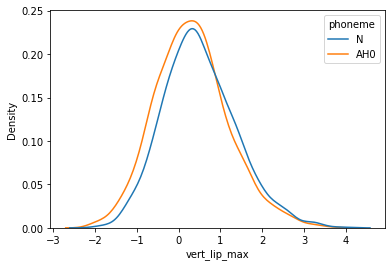

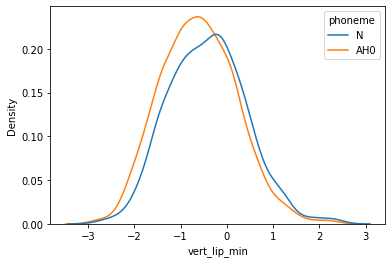

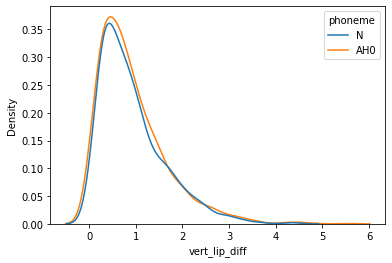

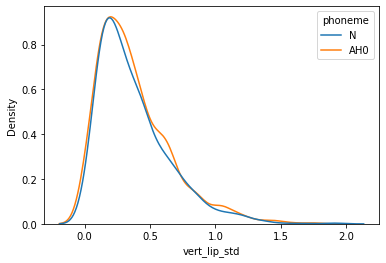

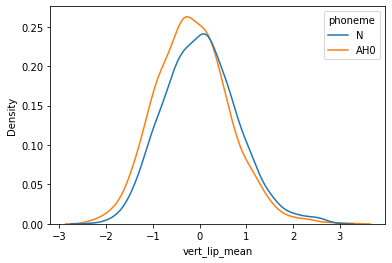

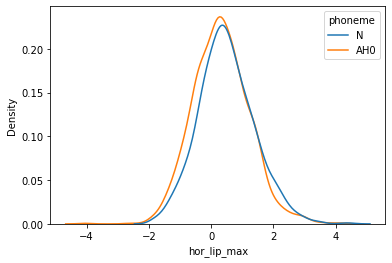

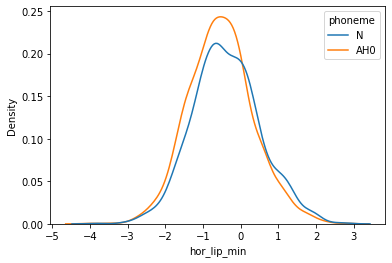

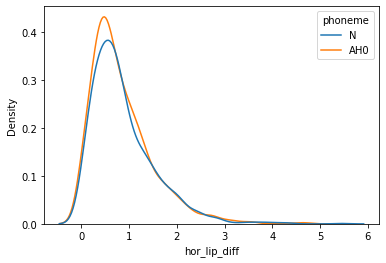

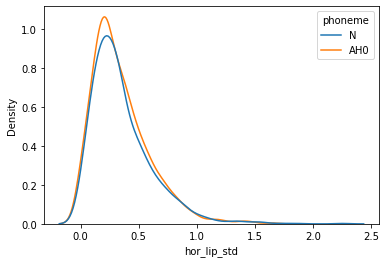

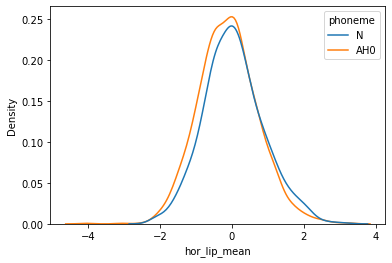

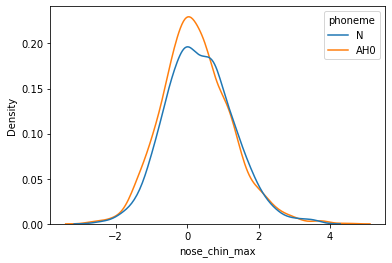

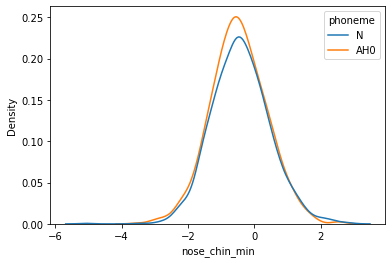

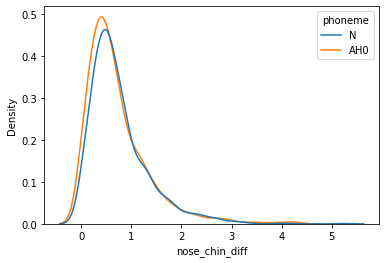

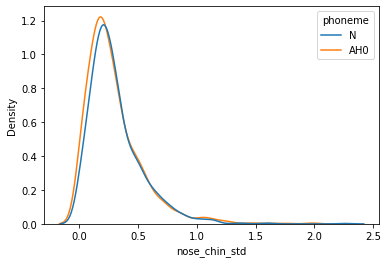

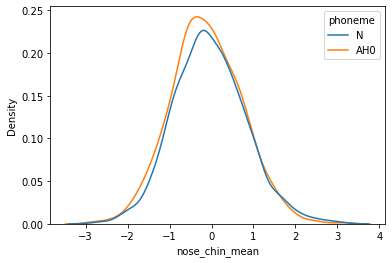

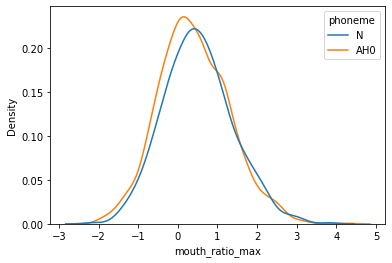

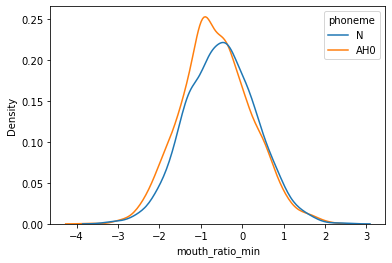

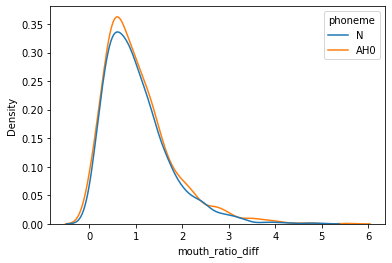

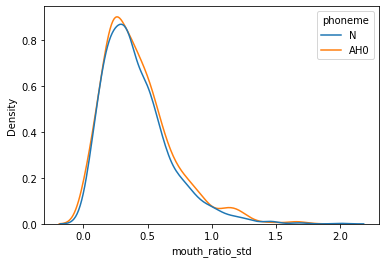

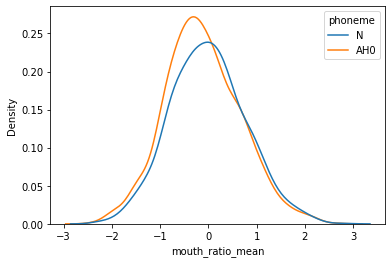

In [35]:
cols = ['vert_lip_max', 'vert_lip_min',
       'vert_lip_diff', 'vert_lip_std', 'vert_lip_mean', 'hor_lip_max',
       'hor_lip_min', 'hor_lip_diff', 'hor_lip_std', 'hor_lip_mean',
       'nose_chin_max', 'nose_chin_min', 'nose_chin_diff', 'nose_chin_std',
       'nose_chin_mean', 'mouth_ratio_max', 'mouth_ratio_min',
       'mouth_ratio_diff', 'mouth_ratio_std', 'mouth_ratio_mean']
for col in cols:
    sns.kdeplot(x=col, hue='phoneme', data=train_df[(train_df['phoneme']=='AH0') | (train_df['phoneme']=='N')])
    plt.show()

In [37]:
train_df['Not_T'] = np.where(train_df['phoneme'] == 'T', 1, 0)

In [ ]:
cols = ['vert_lip_max', 'vert_lip_min',
       'vert_lip_diff', 'vert_lip_std', 'vert_lip_mean', 'hor_lip_max',
       'hor_lip_min', 'hor_lip_diff', 'hor_lip_std', 'hor_lip_mean',
       'nose_chin_max', 'nose_chin_min', 'nose_chin_diff', 'nose_chin_std',
       'nose_chin_mean', 'mouth_ratio_max', 'mouth_ratio_min',
       'mouth_ratio_diff', 'mouth_ratio_std', 'mouth_ratio_mean']
for col in cols:
    sns.kdeplot(x=col, hue='phoneme', data=train_df[(train_df['phoneme']=='AH0') | (train_df['phoneme']=='N')])
    plt.show()